<center><span style="font-size:28px; font-weight:bold;">1 - Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">Nettoyage et analyse exploratoire</span><center>

**Notebook réalisé par Gary MAUGER en Octobre 2024.**

Cette mission concerne l’entreprise....

https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

Utilisation de Ml Flow pour faire le tracking de ce notebook :

Étapes pour vous positionner dans le bon dossier

1. **Ouvrir un terminal.**

2. **Activer l'environnement Conda** :
   ```bash
   conda activate DataScientist_Projet_7
   ```

3. **Naviguer jusqu'au dossier du projet :**
   - Utiliser la commande `cd` pour vous déplacer dans le répertoire contenant le projet. Par exemple :
     ```bash
     cd /Users/Gary/Documents/GitHub/P7_implementer_modele_scoring
     ```

4. **Vérifier à être dans le bon dossier :**
   - Utiliser la commande `ls` (ou `dir` sur Windows) pour lister les fichiers dans le dossier et vous assurer que le répertoire `mlruns` est bien présent.
     ```bash
     ls
     ```
   - le dossier `mlruns` doit être parmi les fichiers listés.

5. **Lancez MLflow UI :**
   - Exécuter la commande suivante pour démarrer l'interface utilisateur de MLflow :
     ```bash
     mlflow ui
     ```

Une fois cela fait, vous pourrez accéder à l'interface utilisateur de MLflow via votre navigateur en visitant `http://127.0.0.1:5000`. 

Nous pouvons spécifier un autre port pour lancer l'interface utilisateur de MLflow. Par exemple, utiliser le port `5001` en lançant la commande suivante :

```bash
mlflow ui --port 5001
```

Ensuite, accéder à l'interface MLflow via le navigateur à l'adresse `http://127.0.0.1:5001`.

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [30]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import missingno as msno

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 - Importation des données

In [4]:
# Initialiser MLFlow
mlflow.set_experiment("Home Credit Default Risk - EDA")

<Experiment: artifact_location='file:///Users/Gary/Documents/GitHub/P7_implementer_modele_scoring/mlruns/129726695521033290', creation_time=1725009641446, experiment_id='129726695521033290', last_update_time=1725009641446, lifecycle_stage='active', name='Home Credit Default Risk - EDA', tags={}>

In [5]:
mlflow.start_run(run_name="Importation des données")

<ActiveRun: >

In [6]:
# Listons les fichiers à notre disposition
display(os.listdir("/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk"))

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [9]:
with mlflow.start_run():
    start_time = time.time()
    
    # Importation des données
    df_application_train = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
    df_application_test = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')
    df_bureau = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv')
    df_credit_card_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv')
    df_bureau_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv')
    df_installments_payments = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv')
    df_POS_CASH_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv')
    df_previous_application = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv')

    # Log des informations pertinentes
    mlflow.log_param("Train Rows", df_application_train.shape[0])
    mlflow.log_param("Test Rows", df_application_test.shape[0])
    mlflow.log_param("Bureau Rows", df_bureau.shape[0])
    mlflow.log_metric("Loading Time", time.time() - start_time)
    mlflow.log_artifact('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', artifact_path="datasets")

**Description du dataset provenant de Kaggle**

**Lien vers le dataset** : [https://www.kaggle.com/c/home-credit-default-risk/data](https://www.kaggle.com/c/home-credit-default-risk/data)

---

1. **application_{train|test}.csv**

   Il s'agit de la table principale, divisée en deux fichiers : un pour l'entraînement (avec la colonne TARGET) et un pour le test (sans la colonne TARGET). Données statiques pour toutes les demandes de prêt. Chaque ligne représente un prêt dans notre échantillon de données.

2. **bureau.csv**

   Tous les crédits précédents du client accordés par d'autres institutions financières et rapportés au Bureau de Crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait au Bureau de Crédit avant la date de la demande.

3. **bureau_balance.csv**

   Soldes mensuels des crédits précédents dans le Bureau de Crédit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Bureau de Crédit – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

4. **POS_CASH_balance.csv**

   Instantanés de solde mensuel des prêts précédents de point de vente (POS) et des prêts en espèces que le demandeur avait avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

5. **credit_card_balance.csv**

   Instantanés de solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois pour lesquels nous avons un historique observable pour la carte de crédit précédente) lignes.

6. **previous_application.csv**

   Toutes les demandes de prêt précédentes chez Home Credit des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

7. **installments_payments.csv**

   Historique des remboursements des crédits précédemment accordés chez Home Credit liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une échéance OU une échéance correspondant à un paiement d'un crédit Home Credit précédent lié aux prêts dans notre échantillon.

8. **HomeCredit_columns_description.csv**

   Ce fichier contient les descriptions des colonnes dans les différents fichiers de données.

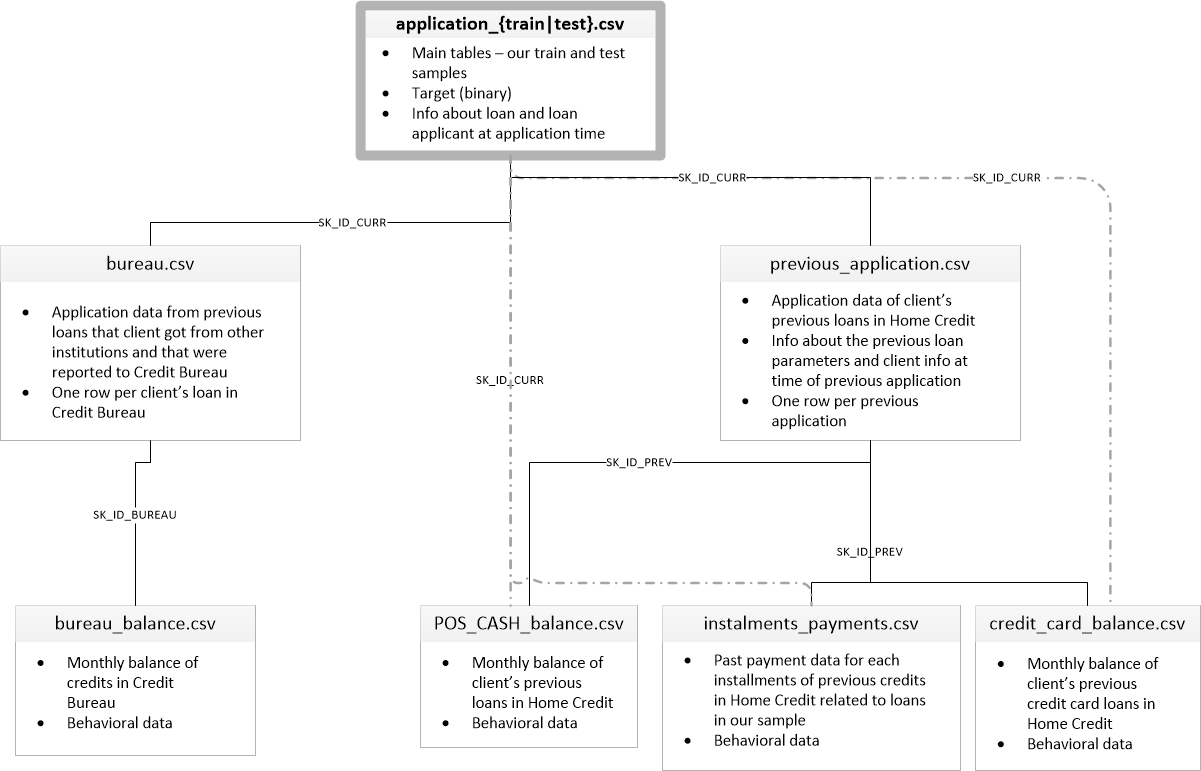

# 2 - Exploration initiale et nettoyage

## 2.1 - Analyses univariées

In [10]:
# On va augmenter l'affichage du nombre de lignes et de colonnes 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [11]:
# Regardons la description de toutes nos variables
df_HomeCredit_columns_description = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
df_HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [16]:
# Liste des DataFrames et leurs noms correspondants
dataframes = {
    'df_application_train': df_application_train,
    'df_application_test': df_application_test,
    'df_bureau': df_bureau,
    'df_bureau_balance': df_bureau_balance,
    'df_credit_card_balance': df_credit_card_balance,
    'df_installments_payments': df_installments_payments,
    'df_POS_CASH_balance': df_POS_CASH_balance,
    'df_previous_application': df_previous_application
}

# Fonction pour résumer un DataFrame
def summarize_df(df, name):
    rows = df.shape[0]
    columns = df.shape[1]
    nan_pct = (df.isnull().sum().sum() / (rows * columns)) * 100
    duplicate_pct = (df.duplicated().sum() / rows) * 100
    object_dtype = df.select_dtypes(include=['object']).shape[1]
    float_dtype = df.select_dtypes(include=['float64']).shape[1]
    int_dtype = df.select_dtypes(include=['int64']).shape[1]
    bool_dtype = df.select_dtypes(include=['bool']).shape[1]
    mb_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # Convertir en MB
    
    return {
        'DataFrame': name,
        'Rows': rows,
        'Columns': columns,
        '%NaN': round(nan_pct, 2),
        '%Duplicate': round(duplicate_pct, 2),
        'object_dtype': object_dtype,
        'float_dtype': float_dtype,
        'int_dtype': int_dtype,
        'bool_dtype': bool_dtype,
        'MB_Memory': round(mb_memory, 3)
    }

In [17]:
# Créer le résumé pour tous les DataFrames
summary = [summarize_df(df, name) for name, df in dataframes.items()]

# Convertir en DataFrame pour l'affichage
df_summary = pd.DataFrame(summary)
df_summary

,DataFrame,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
0,df_application_train,307511,122,24.40,0.0,16,65,41,0,536.692
1,df_application_test,48744,121,23.81,0.0,16,65,40,0,84.735
2,df_bureau,1716428,17,13.50,0.0,3,8,6,0,512.111
3,df_bureau_balance,27299925,3,0.00,0.0,1,0,2,0,1926.608
4,df_credit_card_balance,3840312,23,6.65,0.0,1,15,7,0,875.688
5,df_installments_payments,13605401,8,0.01,0.0,0,5,3,0,830.408
6,df_POS_CASH_balance,10001358,8,0.07,0.0,1,2,5,0,1137.250
7,df_previous_application,1670214,37,17.98,0.0,16,15,6,0,1900.632


1. **Taille des DataFrames**
   - **`df_application_train`** et **`df_application_test`** sont les plus petits en termes de lignes par rapport aux autres DataFrames, mais ils ont le plus grand nombre de colonnes.
   - **`df_bureau_balance`** est de loin le plus grand en termes de nombre de lignes (27 millions), ce qui est attendu pour un historique détaillé des crédits.

2. **Présence de Valeurs Manquantes (%NaN)**
   - Les valeurs manquantes sont assez élevées dans `df_application_train` (24.40%) et `df_application_test` (23.81%). Cela peut indiquer des données incomplètes ou nécessiter un nettoyage approfondi avant la modélisation.
   - Les autres DataFrames ont des pourcentages de valeurs manquantes beaucoup plus faibles, ce qui suggère que les données sont relativement complètes pour ces fichiers.

3. **Duplication des Données (%Duplicate)**
   - Aucun des DataFrames n’a de duplications dans les données (`%Duplicate` est 0.0 pour tous les DataFrames). Cela est bon signe et signifie que les données sont uniques au niveau des lignes.

4. **Types de Données**
   - **`df_application_train`** et **`df_application_test`** contiennent une grande proportion de colonnes d’objets (16), ce qui suggère qu'il y a beaucoup de variables catégorielles. Les autres DataFrames ont un nombre beaucoup plus faible de colonnes d’objets.
   - Les types de données numériques (`float_dtype` et `int_dtype`) sont relativement bien répartis entre les DataFrames, bien que certains DataFrames comme `df_credit_card_balance` et `df_installments_payments` aient une prépondérance de types `float`.

5. **Utilisation de la Mémoire (MB_Memory)**
   - **`df_bureau_balance`** utilise la plus grande quantité de mémoire (1926.608 MB), suivie de près par `df_previous_application` (1900.632 MB). Ces DataFrames ont un grand nombre de lignes, ce qui contribue à leur utilisation élevée de la mémoire.
   - Les DataFrames plus petits comme `df_application_test` et `df_application_train` consomment beaucoup moins de mémoire, ce qui est proportionnel à leur taille plus petite en termes de lignes et de colonnes.

### 2.1.1 - df_application_train/test

In [12]:
# Informations sur df_application_train
df_application_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 536.7 MB


In [13]:
# df_application_train
print('Shape: ', df_application_train.shape)
df_application_train.head()

Shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [18]:
# Informations sur df_application_test
df_application_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 84.7 MB


In [12]:
# df_application_test
print('Shape: ', df_application_test.shape)
df_application_test.head()

Shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

<center><span style="font-size:18px; font-weight:bold;">Notre variable cible</span><center>

Il est important de bien comprendre la distribution de la variable cible (TARGET) car cela influencera les choix de modélisation et de traitement des données.

In [21]:
# Regardons la distribution de notre target
target_distribution = df_application_train['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)
df_application_train['TARGET'].value_counts()

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


TARGET
0    282686
1     24825
Name: count, dtype: int64

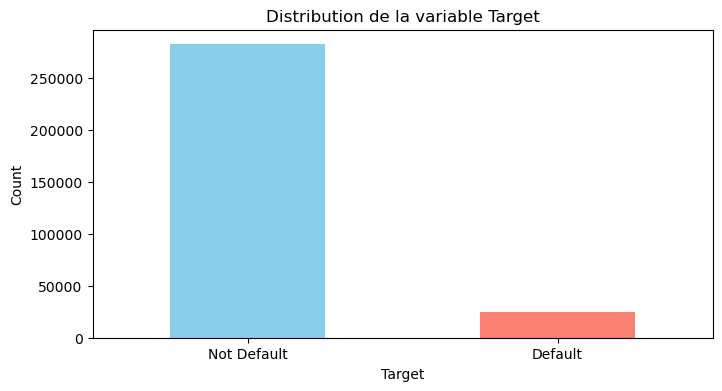

In [24]:
# Plot the target distribution
plt.figure(figsize=(8, 4))
df_application_train['TARGET'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution de la variable Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Default', 'Default'], rotation=0)
plt.show()

La distribution montre un déséquilibre entre les classes, avec une majorité d'échantillons dans la classe 0 (non défaillant) par rapport à la classe 1 (défaillant). Ce déséquilibre est assez fréquent dans les problèmes de classification, en particulier dans les cas de prédiction de défauts de crédit ou de fraude, où les événements de défaut sont généralement rares.


Le déséquilibre des classes peut affecter la performance du modèle de plusieurs façons :
- **Biais du Modèle** : Les modèles peuvent devenir biaisés vers la classe majoritaire (0 dans ce cas) et prédire principalement cette classe.
- **Évaluation du Modèle** : Les métriques classiques comme l'accuracy peuvent être trompeuses. Des métriques comme la précision, le rappel, la F-mesure, et la courbe ROC AUC sont souvent plus appropriées dans les cas de déséquilibre.


Pour traiter le déséquilibre des classes, nous pouvons utiliser plusieurs techniques :
- **Rééchantillonnage** : Utiliser des techniques de suréchantillonnage (par exemple, SMOTE) pour augmenter le nombre d'exemples de la classe minoritaire ou de sous-échantillonnage pour réduire le nombre d'exemples de la classe majoritaire.
- **Pondération des Classes** : Ajuster les poids des classes dans les algorithmes de classification pour donner plus d'importance à la classe minoritaire.
- **Modèles Spécifiques** : Utiliser des modèles conçus pour gérer les déséquilibres, comme les forêts d'arbres décisionnels équilibrées ou les algorithmes de boosting.

<center><span style="font-size:18px; font-weight:bold;">Type des colonnes</span><center>

In [19]:
# Nombre de colonnes de chaque type
df_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

- **Colonnes de Type `float64` :** **65**
  - Ces colonnes contiennent des données numériques à virgule flottante. Elles sont souvent utilisées pour les caractéristiques continues.
  
- **Colonnes de Type `int64` :** **41**
  - Ces colonnes contiennent des données numériques entières. Elles peuvent représenter des comptages, des indicateurs binaires, ou d'autres valeurs discrètes.
  
- **Colonnes de Type `object` :** **16**
  - Ces colonnes contiennent des données de type chaîne de caractères (texte). Elles peuvent inclure des variables catégorielles ou des données textuelles qui doivent être converties en format numérique pour la modélisation.

**Implications pour l'Analyse et le Nettoyage**

- **Colonnes `float64` et `int64` :** 
  - Ces colonnes peuvent nécessiter un traitement pour gérer les valeurs manquantes, les valeurs aberrantes, et la normalisation ou la standardisation des données. 

- **Colonnes `object` :**
  - Les colonnes de type `object` doivent être converties en format numérique avant de pouvoir être utilisées dans les modèles de machine learning. Cela peut être fait par :
    - **Encodage des Catégories :** Utiliser des techniques d'encodage telles que l'encodage par étiquettes (`Label Encoding`) ou l'encodage one-hot (`One-Hot Encoding`) pour transformer les variables catégorielles en variables numériques.
    - **Gestion des Valeurs Manquantes :** Les colonnes de type `object` peuvent contenir des valeurs manquantes ou des catégories peu fréquentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs manquantes</span><center>

In [25]:
# Fonction qui va calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

L'analyse des valeurs manquantes est une étape importante dans le prétraitement des données, surtout lorsqu'il s'agit de préparer les données pour des modèles de machine learning. 

Pour les colonnes avec des pourcentages très élevés de valeurs manquantes :
- **Évaluer la Pertinence**: Déterminer si ces colonnes sont importantes pour notre analyse ou notre modèle. Si elles sont peu informatives ou redondantes, envisager de les supprimer.
- **Imputation ou Suppression**:
  - **Suppression**: Si une colonne a un pourcentage élevé de valeurs manquantes et n’est pas essentielle, nous pouvons la supprimer.
  - **Imputation**: Pour les colonnes essentielles, nous pouvons choisir une méthode d’imputation, comme la moyenne, la médiane, ou une méthode basée sur d’autres colonnes (comme la régression ou les techniques d’imputation avancées).

In [26]:
# Affichons les valeurs manquantes :
missing_values = missing_values_table(df_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [37]:
# Affichons les valeurs manquantes :
missing_values_test = missing_values_table(df_application_test)
missing_values_test.head(20)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


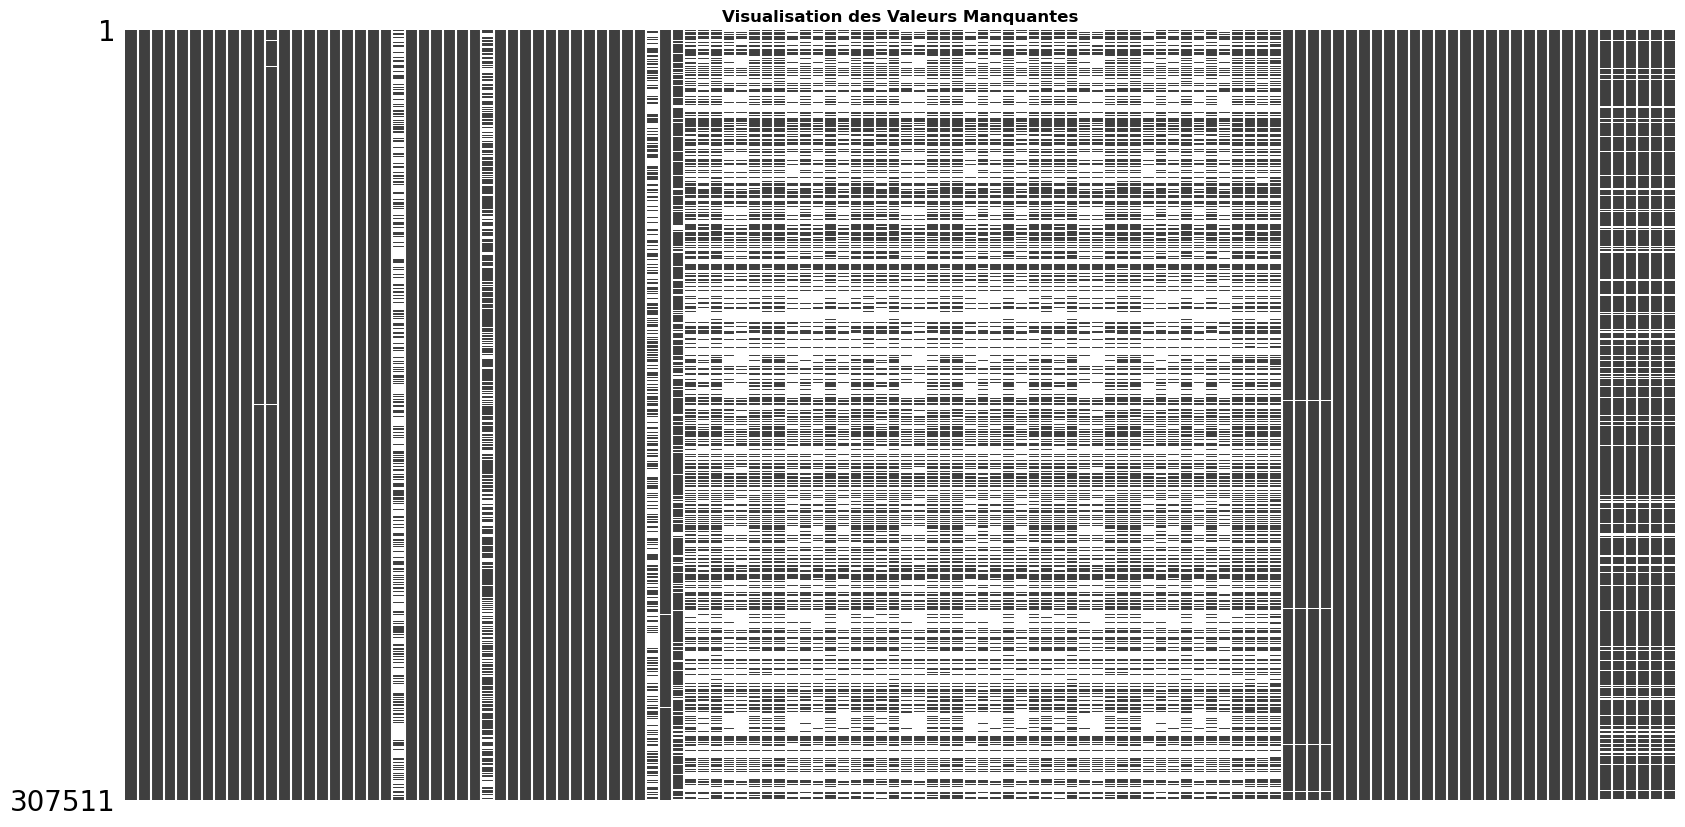

In [35]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_train, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Train", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

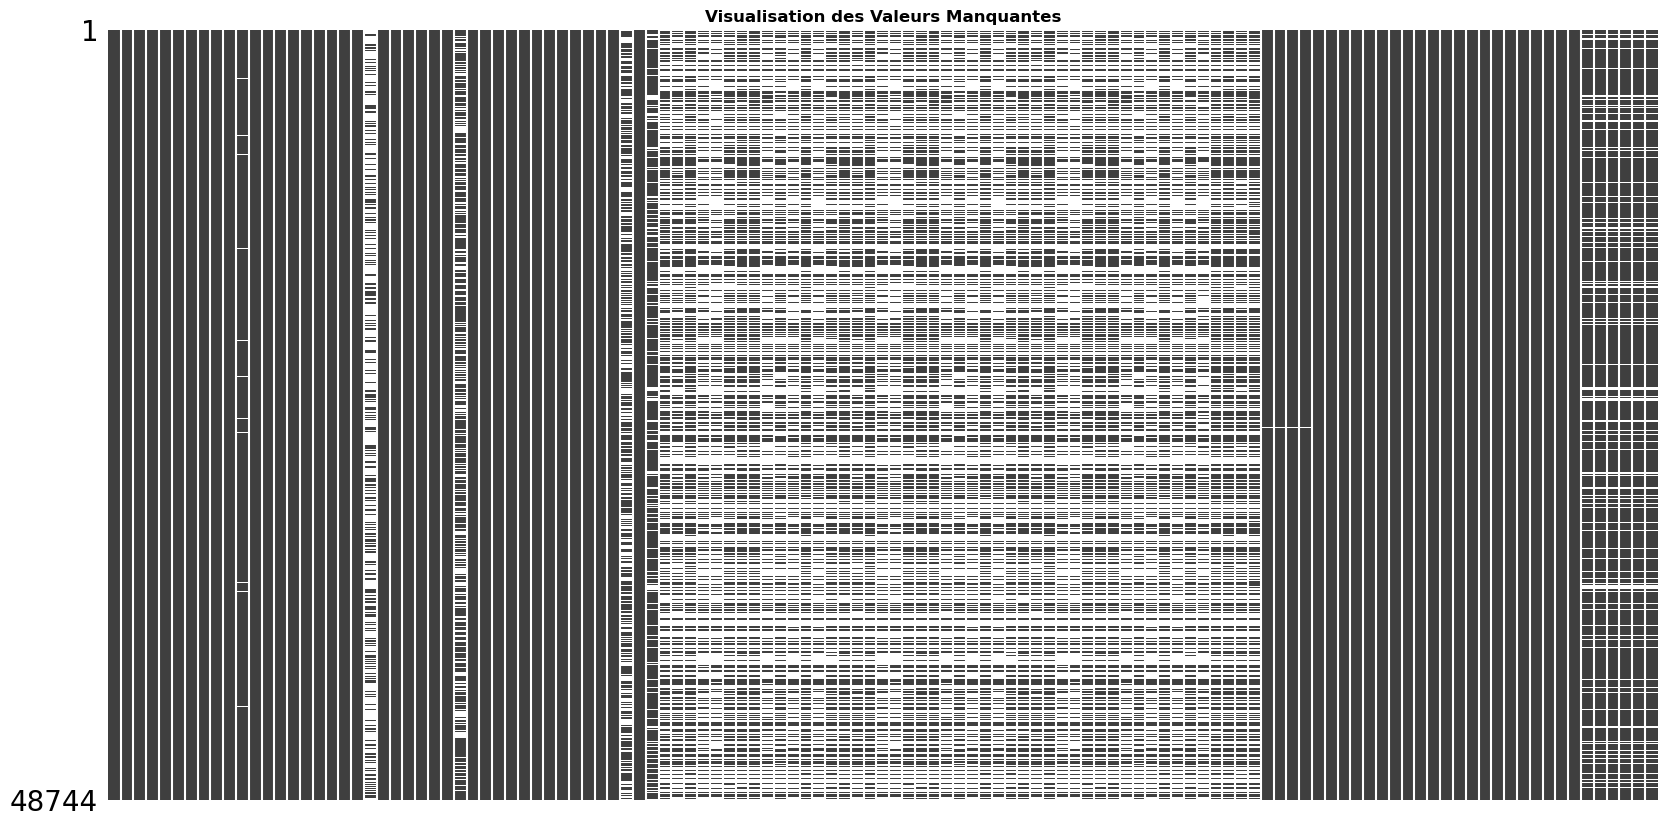

In [36]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_test, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Test", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

En modélisation, notamment avec des algorithmes comme XGBoost, il est souvent possible de gérer les valeurs manquantes directement, car ces modèles peuvent travailler avec des données incomplètes de manière plus robuste que certains autres types de modèles. 

1. **Distribution des Valeurs Manquantes**
   - **Colonnes Concernées**: Les valeurs manquantes sont principalement concentrées dans les caractéristiques liées aux habitats et non dans les variables liées aux crédits.
   - **TOP 20 des Colonnes avec Plus de NaN**: Les colonnes relatives aux caractéristiques des habitats (comme `COMMONAREA_MEDI`, `LIVINGAPARTMENTS_MODE`, etc.) présentent des taux très élevés de valeurs manquantes.

&nbsp;
2. **Implications pour le Modèle**
   - **Impact Potentiel**: Les caractéristiques avec des valeurs manquantes élevées peuvent influencer la qualité de la modélisation si elles sont importantes pour la prédiction. Cependant, les modèles comme XGBoost peuvent traiter les NaN nativement, ce qui simplifie la prétraitement des données.
   - **Évaluation de l'Importance**: Puisqu'on ne peut pas toujours anticiper l'importance de ces variables pour le modèle, il est prudent de ne pas les éliminer immédiatement sans analyse plus approfondie.

&nbsp;
3. **Analyse de l'Importance des Variables**
   - **Importance des Variables**: Nous allons utiliser des méthodes comme l’analyse de l'importance des variables (feature importance) après une première modélisation pour identifier quelles variables sont réellement pertinentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs uniques</span><center>

Analyser le nombre de valeurs uniques dans les colonnes catégorielles va nous aider à comprendre la diversité des catégories présentes dans notre dataset.

In [20]:
# Nombre de valeurs uniques pour les colonnes object
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1. **Colonnes avec Peu de Catégories**
   - **`NAME_CONTRACT_TYPE`, `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `EMERGENCYSTATE_MODE`**:
     - Ces colonnes ont 2 valeurs uniques, ce qui indique qu’elles contiennent des variables binaires. Elles sont généralement simples à traiter car elles ne nécessitent pas une grande complexité pour la modélisation.

2. **Colonnes avec Modéré Nombre de Catégories**
   - **`NAME_TYPE_SUITE`, `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, `NAME_HOUSING_TYPE`, `WEEKDAY_APPR_PROCESS_START`, `FONDKAPREMONT_MODE`, `HOUSETYPE_MODE`, `WALLSMATERIAL_MODE`**:
     - Ces colonnes ont un nombre modéré de valeurs uniques (entre 3 et 18). Elles contiennent des variables catégorielles avec plusieurs options, ce qui peut nécessiter une transformation en variables numériques (par exemple, via l'encodage).

3. **Colonnes avec Nombre Élevé de Catégories**
   - **`OCCUPATION_TYPE`, `ORGANIZATION_TYPE`**:
     - Ces colonnes ont un grand nombre de valeurs uniques (respectivement 18 et 58). Elles représentent des variables avec une grande diversité de catégories, ce qui peut nécessiter des techniques spécifiques comme l'encodage par entités, ou l'utilisation de méthodes pour gérer le cardinalité élevée.

<center><span style="font-size:18px; font-weight:bold;">Encodage des variables catégorielles</span><center>

1. **Encodage des Variables Catégorielles**
   - **Variables Binaires**: Les colonnes avec 2 valeurs uniques peuvent être converties en variables binaires directement (0 ou 1).
   - **Variables avec Modéré Nombre de Catégories**: Nous pouvons utiliser l'encodage one-hot (ou dummies) pour ces variables. Cette méthode crée des colonnes supplémentaires pour chaque catégorie.
   - **Variables avec Nombre Élevé de Catégories**: Pour les variables avec un grand nombre de catégories, nous pouvons envisager l’encodage par entités ou le regroupement des catégories rares. L'encodage one-hot peut entraîner un très grand nombre de colonnes, ce qui peut ne pas être optimal.

2. **Gestion des Variables à Cardinalité Élevée**
   - **Réduction de Cardinalité**: Nous pouvons regrouper les catégories rares ou peu fréquentes sous une catégorie commune (par exemple, "Autre").
   - **Encodage par Entités**: Nous pouvons utiliser des techniques d'encodage basées sur les cibles (target encoding) ou des encodages fréquents pour ces colonnes.

Le code suivant sert à encoder les colonnes catégorielles avec un nombre de valeurs uniques inférieur ou égal à 2 en utilisant `LabelEncoder` de la bibliothèque `sklearn`.

In [21]:
# Création du LabelEncoder
le = LabelEncoder()
le_count = 0

# Itérons toutes les colonnes
for col in df_application_train:
    if df_application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application_train[col])
            # Transform both training and testing data
            df_application_train[col] = le.transform(app_train[col])
            df_application_test[col] = le.transform(df_application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


Le `one-hot encoding` suivant va transformer nos variables catégorielles en colonnes binaires pour chaque valeur unique.

In [22]:
# One-hot encoding des variables catégorielles
df_application_train = pd.get_dummies(df_application_train)
df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Il y a une différence dans le nombre de colonnes entre les ensembles de données d'entraînement et de test :
- **Entraînement**: 243 colonnes
- **Test**: 239 colonnes

Cette différence de colonnes est souvent due à des catégories présentes dans l'ensemble d'entraînement mais absentes dans l'ensemble de test (ou vice versa). Cela peut poser problème pour les modèles, car chaque ensemble de données doit avoir les mêmes colonnes pour que la modélisation soit cohérente.

Nous pouvons résoudre ce problème en garantissant que les deux ensembles de données (entraînement et test) ont les mêmes colonnes après `one-hot encoding`.

In [23]:
train_labels = df_application_train['TARGET']

# Alignons les deux ensembles, en ne gardant que les colonnes présentent dans les deux dataframes
df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)

# On rajout la TARGET
df_application_train['TARGET'] = train_labels

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


<center><span style="font-size:18px; font-weight:bold;">Gestion des anomalies</span><center>

Un problème auquel nous devons toujours être attentifs lors de l'exploration des données est la détection des anomalies. Celles-ci peuvent être dues à des erreurs de saisie, des problèmes avec les équipements de mesure, ou bien elles peuvent représenter des mesures valides mais extrêmes. Une façon de détecter quantitativement les anomalies est d'examiner les statistiques d'une colonne en utilisant la méthode `describe`."

In [27]:
# Cherchons des anomalies pour nos variables integer
df_application_train.select_dtypes('int64').describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,...,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.080729
std,102790.175348,0.293509,0.473746,0.460968,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,...,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# Cherchons des anomalies pour nos variables float
df_application_train.select_dtypes('float64').describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year.

In [24]:
# Regardons notre variable DAYS_BIRTH
df_application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [25]:
# Nous pouvons voir ces stats en années
(df_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [29]:
# Regardons notre variable DAYS_EMPLOYED
df_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [33]:
# Nous pouvons voir ces stats en années
(df_application_train['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [34]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

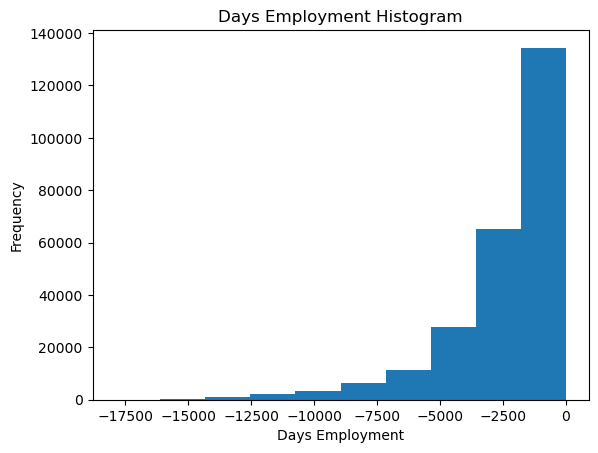

In [35]:
# Create an anomalous flag column
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [36]:
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


## 2.2 - Analyses bivariées

Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”

In [37]:
# Find correlations with the target and sort
correlations = df_application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

# 3 - Création du df_final

Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations.

In [ ]:
# On va créer un premier dataframe en faisant un merge de df_application_train et df_application_test
df_final = df_application_train.append(df_application_test)

Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.

In [ ]:
print('Train:' + str(application_train.shape))
print('Test:' + str(application_test.shape))
print('>>> Data:' + str(data.shape))

In [ ]:
# Vérifions nos valeurs manquantes de TARGET dans notre df_final
df_final.TARGET.isna().sum()

A partir du fichier bureau.csv, il est possible d'extraire un historique sur les précédents crédits enregistrés par les clients. Il peut donc être intéressant d'enrichir l'échantillon avec ce type de données.